<a href="https://colab.research.google.com/github/Harshan2301/NEURAL-STYLE-TRANSFER/blob/main/NEURALSTYLE_TRANSFER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Optimizing...
Step 50: Style Loss 0.0000, Content Loss 2.1158
Step 100: Style Loss 0.0000, Content Loss 2.0471
Step 150: Style Loss 0.0000, Content Loss 2.1097
Step 200: Style Loss 0.0000, Content Loss 2.0871
Step 250: Style Loss 0.0000, Content Loss 2.0898
Step 300: Style Loss 0.0000, Content Loss 2.0490


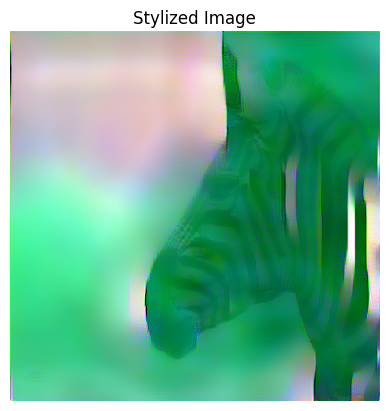

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# Load and preprocess images
def load_image(path, size=400):
    image = Image.open(path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((size, size)),  # Make both images 400x400
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0).to(device)
    return image


# Display image
def imshow(tensor, title=''):
    image = tensor.cpu().clone().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.title(title)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Content and Style Loss Classes
class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()

    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = self.gram_matrix(target_feature).detach()

    def gram_matrix(self, x):
        b, c, h, w = x.size()
        features = x.view(b * c, h * w)
        G = torch.mm(features, features.t())
        return G.div(b * c * h * w)

    def forward(self, x):
        G = self.gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x

# Main neural style transfer logic
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1e6, content_weight=1):
    cnn = cnn.features.eval()
    content_layers = ['conv_4']
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
    model = nn.Sequential()
    content_losses = []
    style_losses = []

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)

    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("Optimizing...")
    run = [0]
    while run[0] <= num_steps:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)
            loss = style_weight * style_score + content_weight * content_score
            loss.backward()
            run[0] += 1
            if run[0] % 50 == 0:
                print(f"Step {run[0]}: Style Loss {style_score.item():.4f}, Content Loss {content_score.item():.4f}")
            return loss
        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img

# --- Usage ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
content_path = '/content/9955613-PQMHPVED-7.jpg'  # Replace with your image
style_path = '/content/images.png'      # Replace with your image

content_img = load_image(content_path, size=400)
style_img = load_image(style_path, size=400)
input_img = content_img.clone()

# Load pre-trained VGG19
cnn = models.vgg19(pretrained=True).to(device).eval()

output = run_style_transfer(cnn, content_img, style_img, input_img)
imshow(output, title="Stylized Image")
